In [ ]:
#imports

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models

from tensorflow.keras import layers, optimizers
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [ ]:
from keras.datasets import reuters

 (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000)


2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
#List all the hyperparameters
parameters = [
    [250, [(4,)], 0.1],
    [250, [(16,)], 0.1],
    [250, [(32, 16)], 0.1],
    [500, [(16,)], 0.1],
    [500, [(64, 32, 16)], 0.01],
    [1000, [(32,16)], 0.001],
    [1000, [(128, 64, 32, 16)], 0.001],
    [5000, [(64, 32, 16)], 0.0001],
    [5000, [(128, 64, 32, 16)], 0.001],
    [5000, [(128, 64, 32, 16)], 1e-05],
    [5000, [(256, 128, 64, 32, 16)], 0.0001],
    [5000, [(256, 128, 64, 32, 16)], 0.00001],
]

num_epochs = 20

batch_size = 512

In [ ]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))

    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data

x_trainset = vectorize_sequences(x_train)

# Our vectorized test data

x_testset = vectorize_sequences(x_test)

print(x_trainset.shape)

(8982, 10000)


In [ ]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_y_train = to_one_hot(y_train)

# Our vectorized test labels
one_hot_y_test = to_one_hot(y_test)

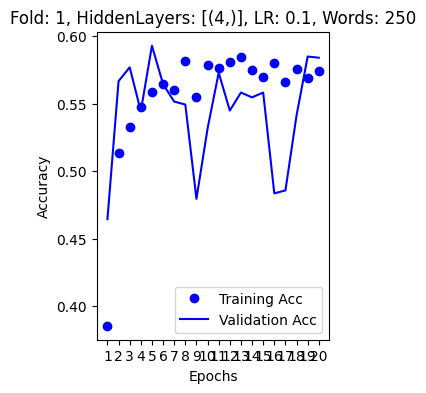

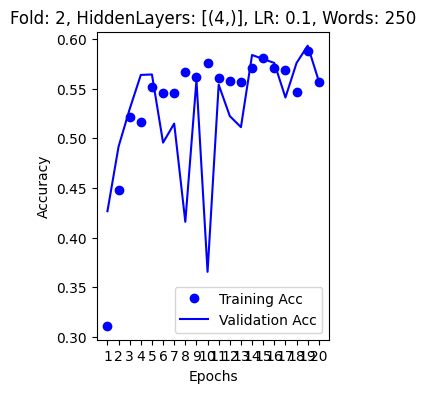

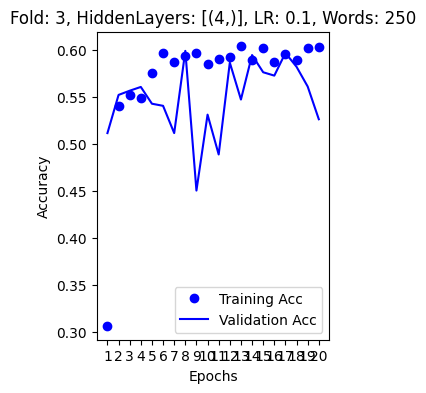

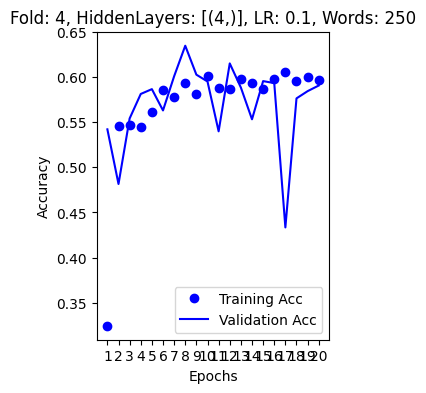

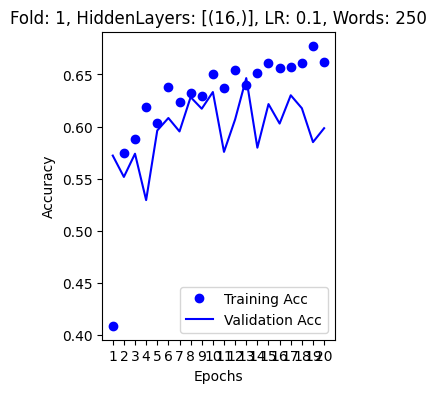

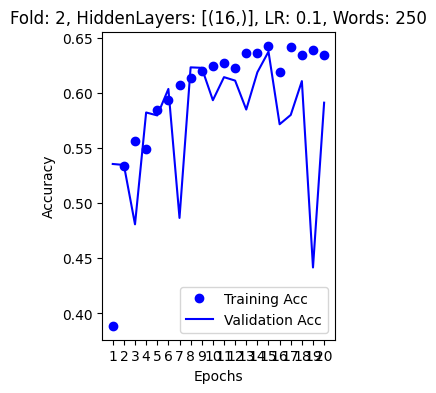

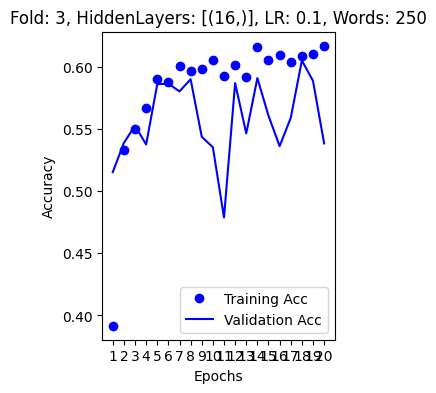

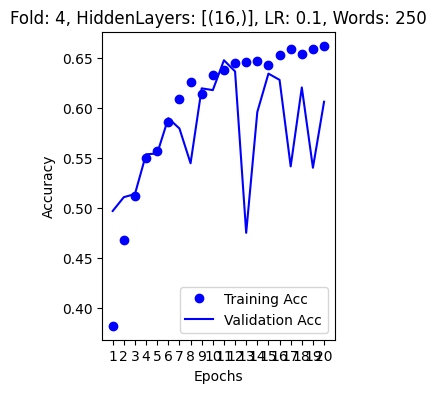

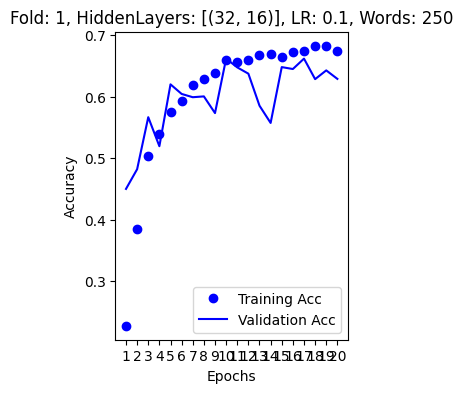

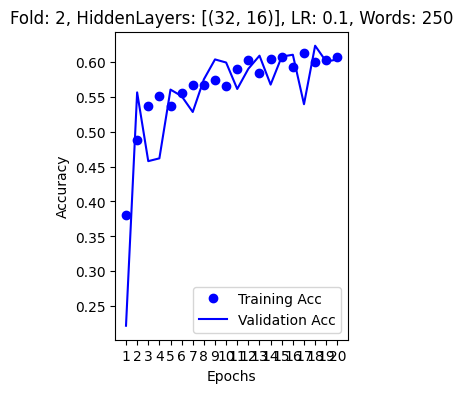

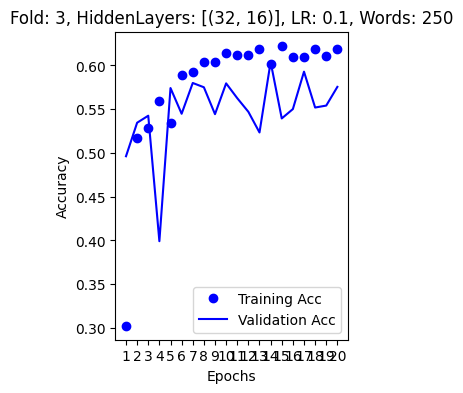

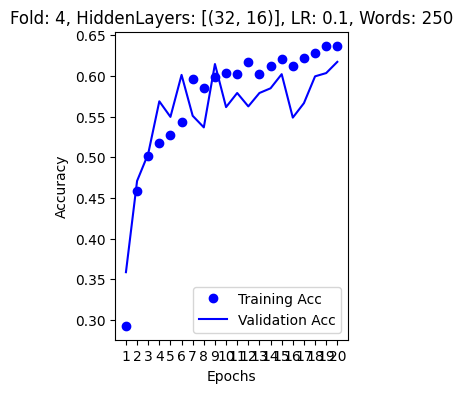

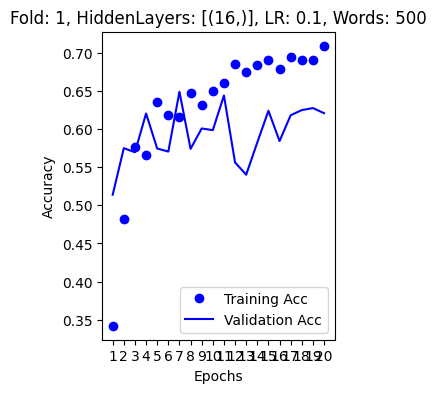

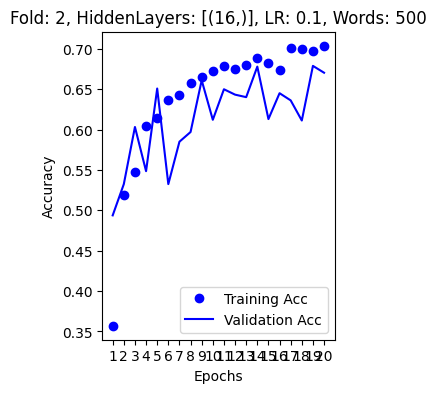

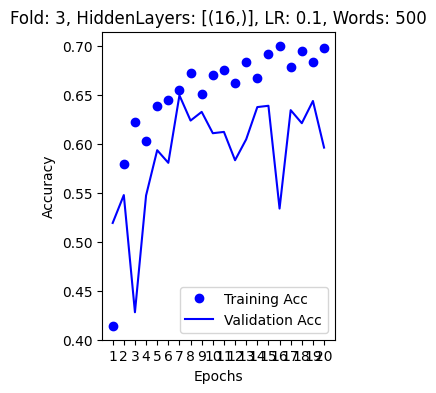

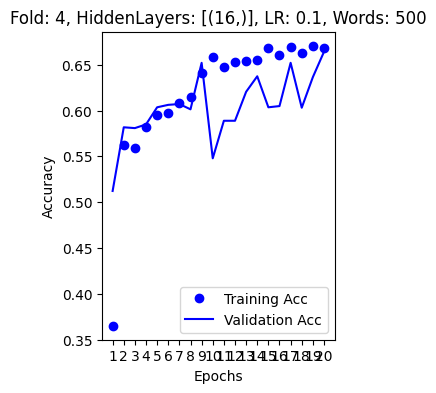

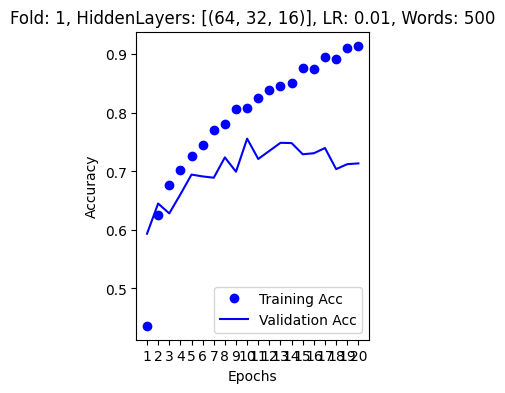

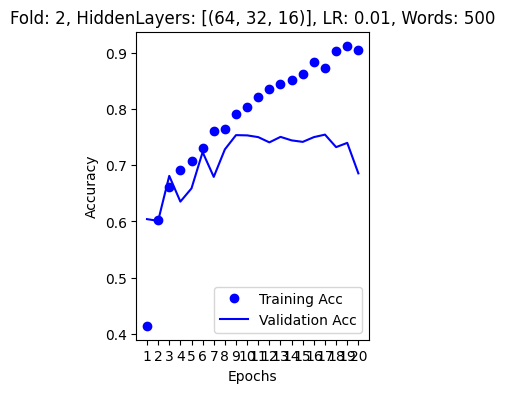

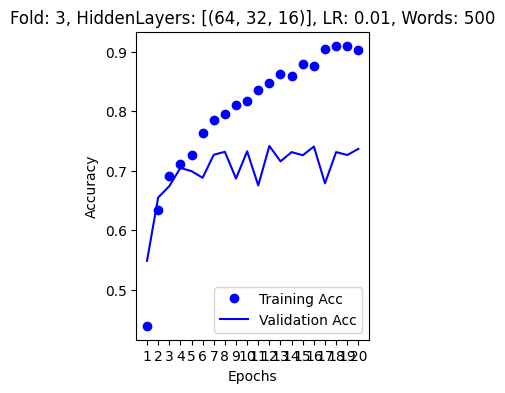

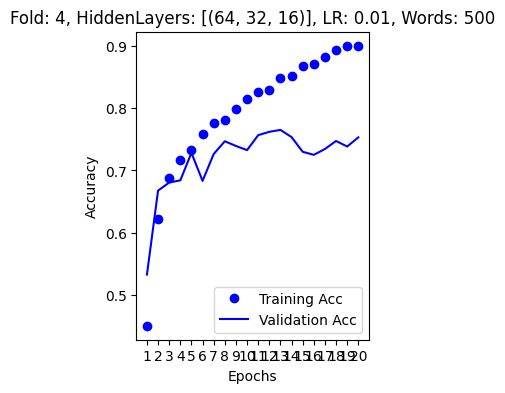

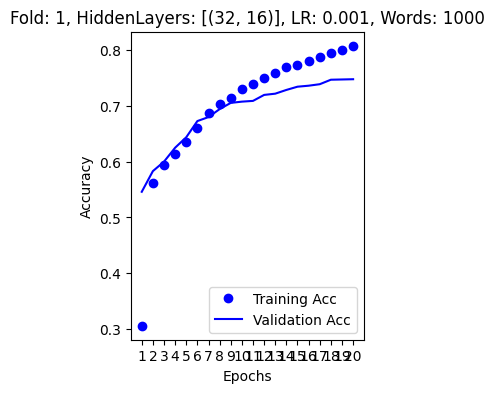

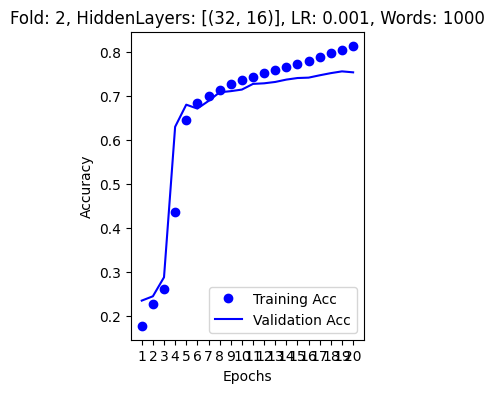

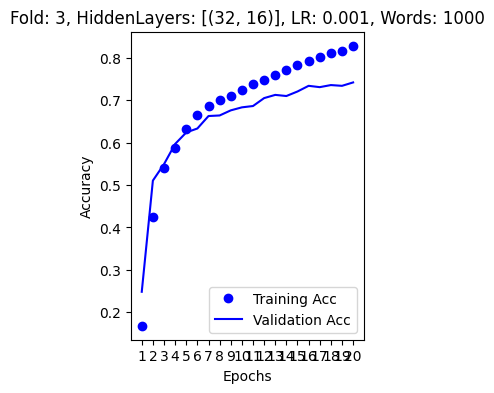

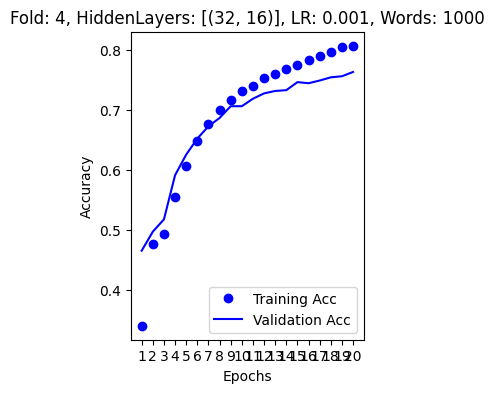

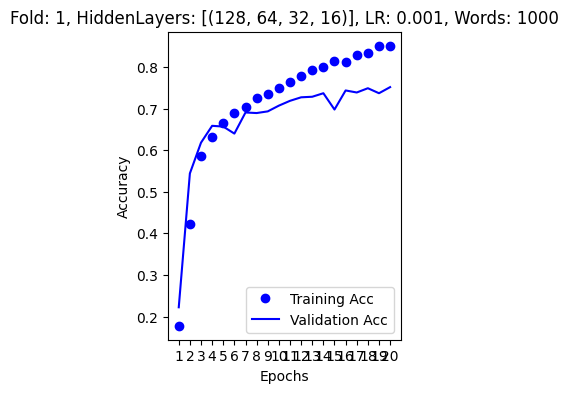

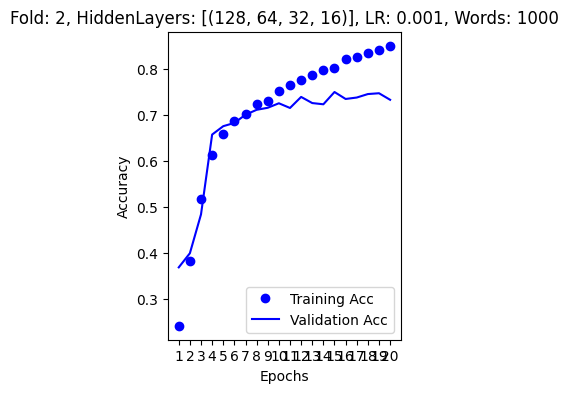

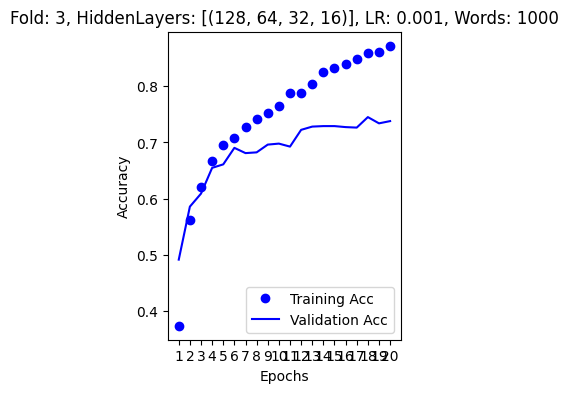

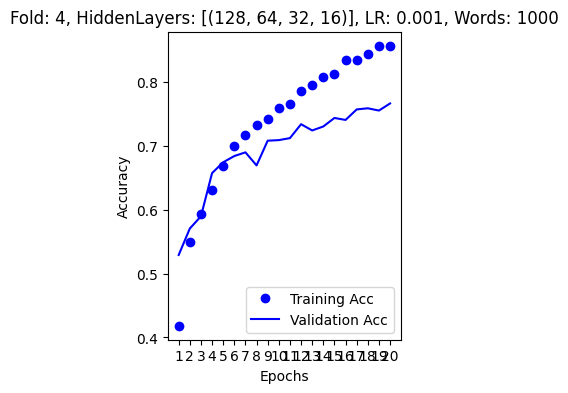

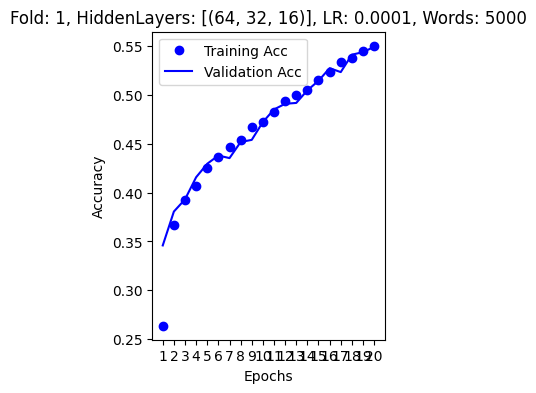

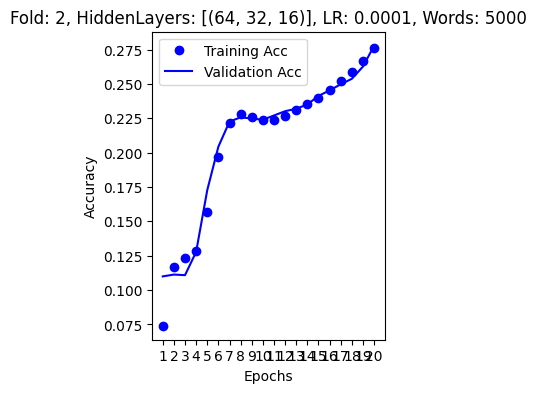

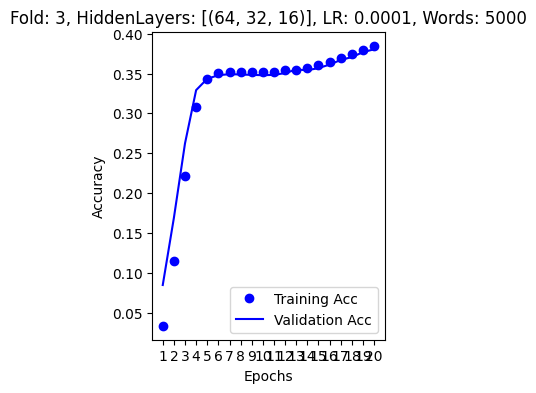

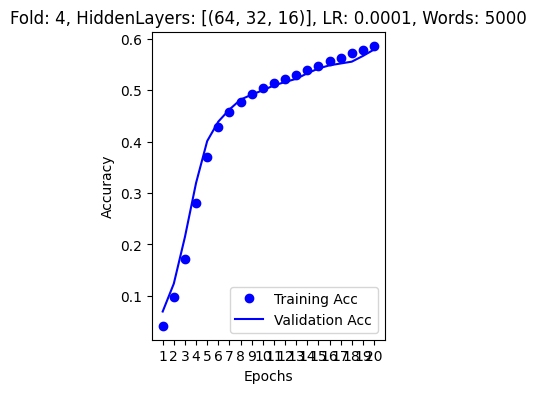

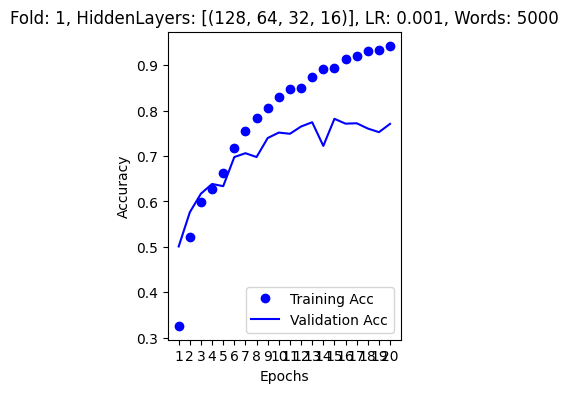

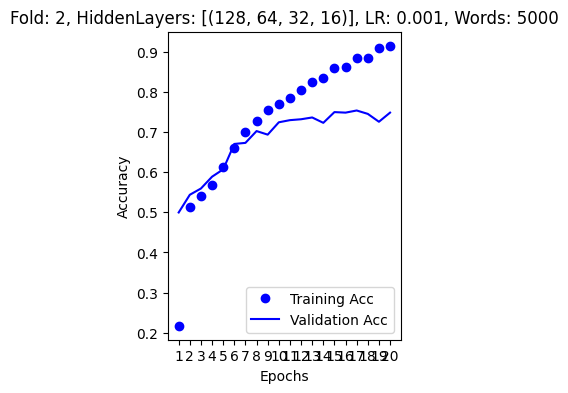

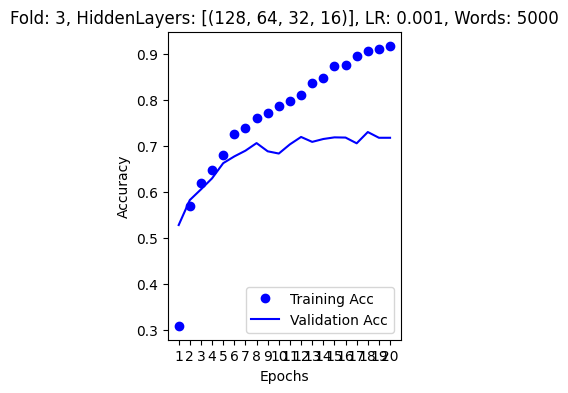

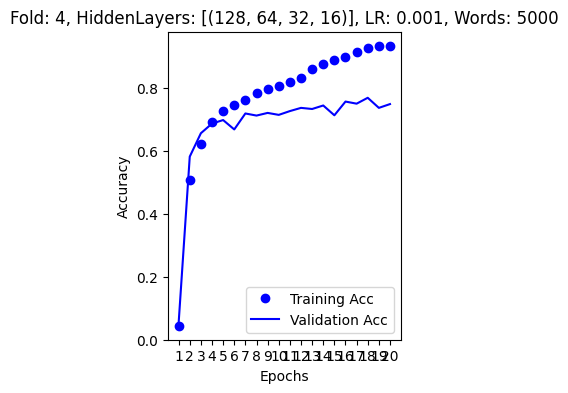

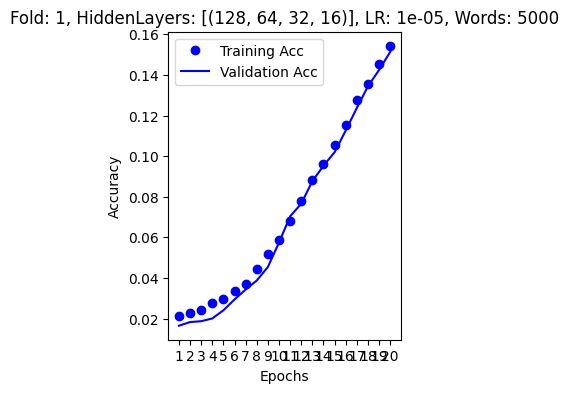

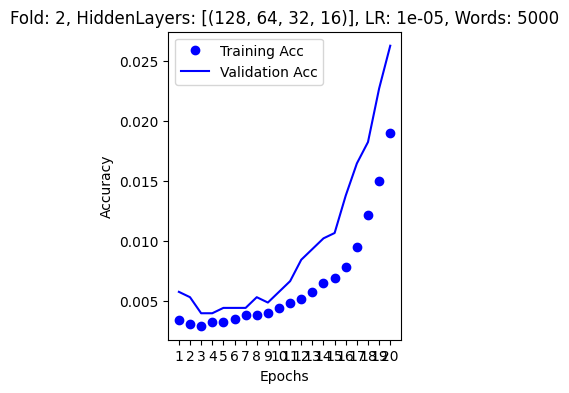

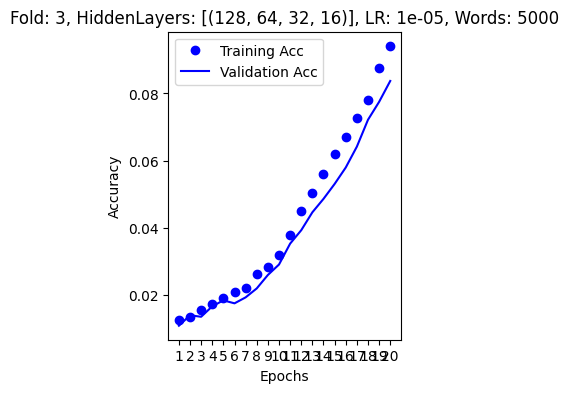

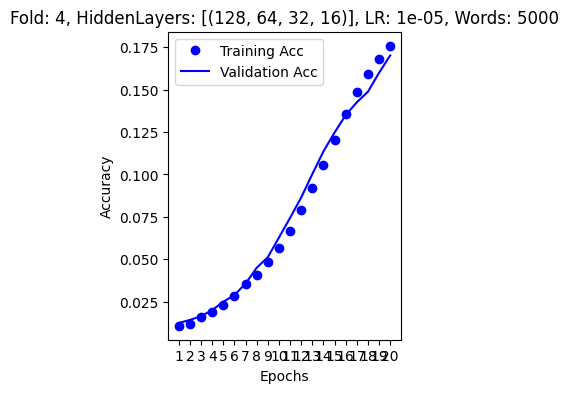

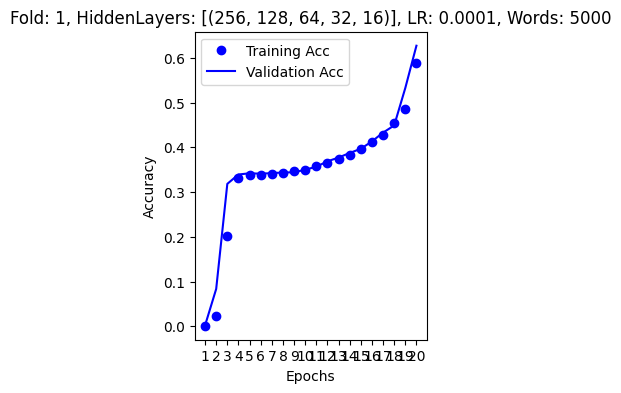

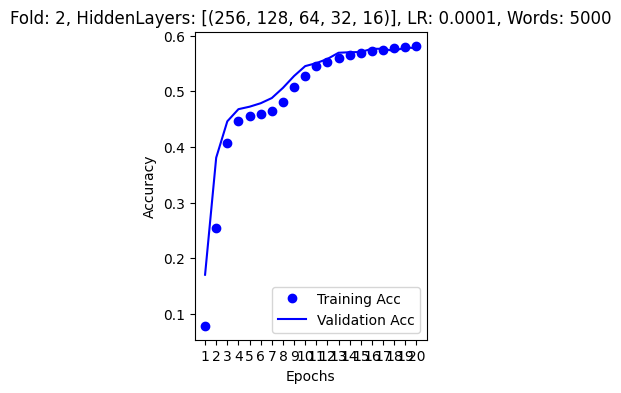

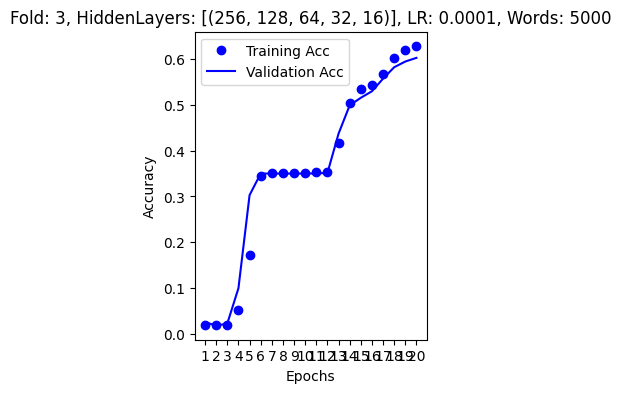

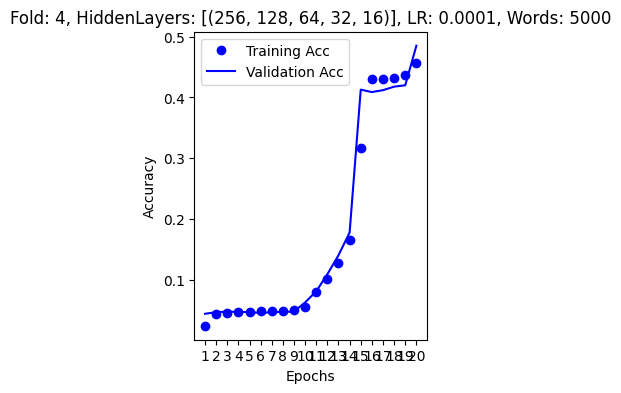

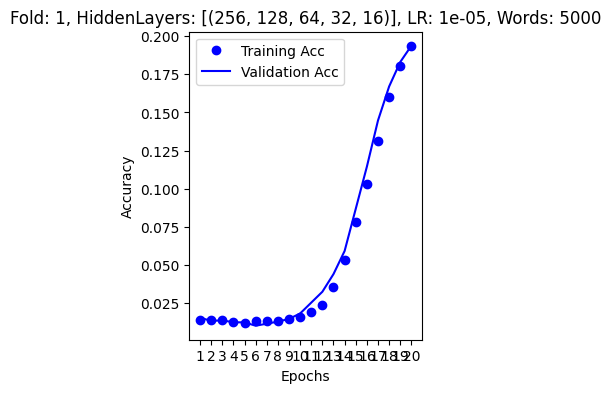

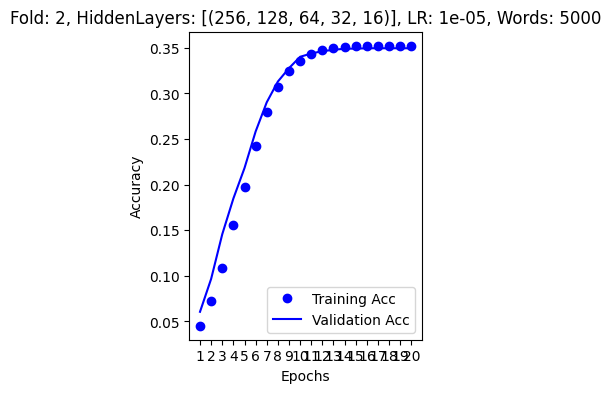

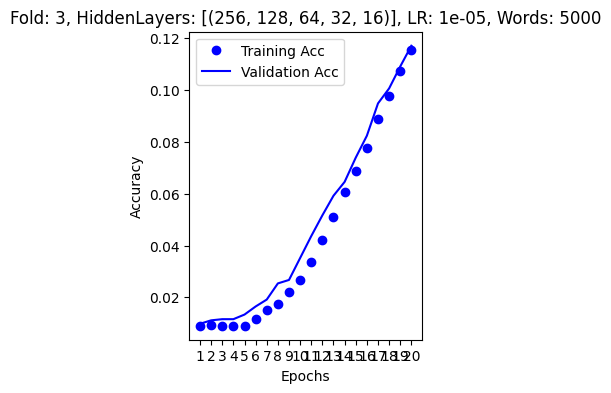

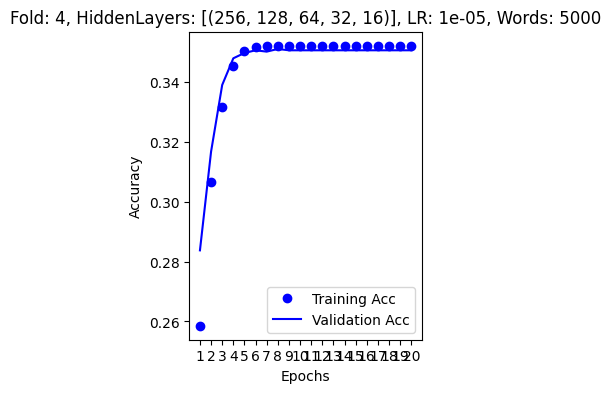

In [ ]:
result = []


fold_count = 0


validation = np.zeros((48, 20))


for num_word, layer, lr in parameters:

  x_training = x_trainset[:, :num_word]

  x_testing = x_testset[:, :num_word]

  for i, (train_index, val_index) in enumerate(kf.split(x_training)):
    x_tfold, x_vfold = x_training[train_index], x_training[val_index]

    y_tfold, y_vfold = one_hot_y_train[train_index], one_hot_y_train[val_index]

    model = models.Sequential()
    model.add(layers.Input(shape=(num_word,)))

    for num_nodes in layer[0]:

      model.add(layers.Dense(num_nodes, activation='relu'))

    model.add(layers.Dense(46, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=lr),
                metrics=['accuracy'])

    history = model.fit(x_tfold,
                      y_tfold,
                      epochs=num_epochs,
                      batch_size=512,
                      validation_data=(x_vfold, y_vfold), verbose=0)

    train_ac = history.history['accuracy']
    #
    val_acc = history.history['val_accuracy']

    train_loss = np.array(history.history['loss'])

    val_loss = history.history['val_loss']


    if fold_count < 48:
      validation[fold_count] = val_acc
      fold_count += 1


    # plot training and validation accuracy FOR each FOLD
    plt.figure(figsize=(3,4))

    plt.plot( range(1, len( train_ac ) +   1 ), train_ac, 'bo', label='Train Acc')

    plt.plot( range( 1, len( val_acc ) + 1), val_acc, 'b-', label='Valid Acc')

    plt.title(f' fold: {i+1}, HiddenLayers: {layer}, LearningR: {lr}, Words: {num_word}')

    plt.xticks(range(1,21,1))
    plt.xlabel('epochs')

    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


    # calculate and plot average validation accuracy for 4 folds
    avg_val_acc = np.mean(val_acc, axis=0)

    result.append((num_word, layer, lr, avg_val_acc))

In [ ]:
# selecting 3 top options

top_choices = sorted(result, key=lambda x:x[3], reverse=True)[:3]

print("Here are three top choices")

for i, option in enumerate(top_choices):

  print(f"Ranking {i+1}: number of words={option[0]}, Hiddenlayers={option[1]}, Learning = {option[2]}, ValidAccuracy={option[3]}")

3 top choices
Ranking 1: number of words=500, Hidden layers=[(64, 32, 16)], LearningRate = 0.01, Validation accuracy=0.7194654673337937
Ranking 2: number of words=500, Hidden layers=[(64, 32, 16)], LearningRate = 0.01, Validation accuracy=0.7105075716972351
Ranking 3: number of words=5000, Hidden layers=[(128, 64, 32, 16)], LearningRate = 0.001, Validation accuracy=0.7088824540376664


In [ ]:
# let's take a look at the three choices here

for i, (word, hidden_layer, lr, _) in enumerate(top_choices):

  model = models.Sequential()

  model.add(layers.Input(shape=(word,)))

  for node in hidden_layer[0]:

    model.add(layers.Dense(node, activation='relu'))

  model.add(layers.Dense(46, activation='softmax'))

  model.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy']
               )

  model.fit(x_trainset[:, :word],
            one_hot_y_train,
            batch_size=512, verbose=0)

  test_loss, test_accuracy = model.evaluate(x_testset[:, :word],
                                            one_hot_y_test)

  prediction = model.predict(x_testset[:, :word])

  print(f'Model ranking {i+1}: test accuracy = {test_accuracy:.4f}, test loss = {test_loss:.4f}')


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5547 - loss: 1.7001
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model ranking 1: test accuracy = 0.5508, test loss = 1.7085
Model ranking 1: sample prediction = [[2.44672776e-07 6.85011109e-05 4.16461080e-06 9.92002845e-01
  6.36079302e-03 3.94545694e-08 1.27804651e-05 8.97250274e-08
  1.22196827e-04 3.98529835e-07 1.17913271e-06 2.12794057e-05
  9.05652905e-06 6.44906759e-05 3.16470079e-07 2.23023888e-09
  4.78248141e-04 2.64673599e-06 4.77928279e-06 2.12791219e-05
  6.15744721e-05 1.11681926e-04 2.20780180e-06 3.64267180e-06
  7.73756256e-06 1.02038721e-04 1.09123988e-09 9.13422493e-09
  3.52994050e-07 4.21901814e-06 1.42925783e-04 1.40116725e-04
  2.24458727e-08 1.85541314e-04 5.94841276e-06 2.44984733e-07
  4.30047294e-05 2.59000075e-07 4.20960896e-06 4.56316911e-06
  4.27507274e-08 3.92006541e-06 6.11630000e-08 3.04296378e-07
  1.39960443e-08 3.16107958e-08]
 [1.05004432e-02 7.07985014e-02 1.68132540e-02 1.22403726e-01
  7.72323981e-